# Historische Simulation versus Varianz-Kovarianz-Methode

© Thomas Robert Holy 2019
<br>
Version 0.9.7

## Voraussetzungen:

- An dieser Stelle ist bereits alles vorbereitet 
<br>
- Das Notebook lässt sich bereits vollständig mit fiktiven Aktienkursen ausführen

### Optional:

Um ein Portfolio mit echten Aktienkursen zusammenzustellen, können im Home-Verzeichnis bis zu fünf .csv-Datein hochgeladen werden. Diese müssen die folgenden Kriterien erfüllen:
<br>
- Sie umfassen alle denselben Zeitraum
<br>
- Es wird ein Punkt zur Dezimaltrennung verwendet
<br>
- Es wird ein Komma zur Spaltentrennung verwendet

<br>
Abrufbar sind die Daten z.B. hier: https://de.finance.yahoo.com/

## Grundlegende Einstellungen:

Zunächst müssen die notwendigen Pakete (auch Module) importiert werden, damit auf diese zugegriffen werden kann. 

In [ ]:
import numpy as np # Programmbibliothek die eine einfache Handhabung von Vektoren, Matrizen oder generell großen mehrdimensionalen Arrays ermöglicht
import pandas as pd # Programmbibliothek die Hilfsmittel für die Verwaltung von Daten und deren Analyse anbietet
import matplotlib.pyplot as plt # Programmbibliothek die es erlaubt mathematische Darstellungen aller Art anzufertigen
import matplotlib.patches as mpatches
import operator # Programmbibliothek, welche die Ausgaben übersichtlicher gestaltet
import datetime as dt # Das datetime-Modul stellt Klassen bereit, mit denen Datums- und Uhrzeitangaben auf einfache und komplexe Weise bearbeitet werden können
import sys # Dieses Modul bietet Zugriff auf einige Variablen, die vom Interpreter verwendet oder verwaltet werden, sowie auf Funktionen, die stark mit dem Interpreter interagieren
from scipy import stats # SciPy ist ein Python-basiertes Ökosystem für Open-Source-Software für Mathematik, Naturwissenschaften und Ingenieurwissenschaften

Anschließend werden Einstellungen definiert, die die Formatierung der Ausgaben betreffen.
Hierfür wird das Modul `operator` genutzt.
Außerdem wird die Breite des im Folgenden genutzten DataFrames erhöht und die Größe der Grafiken modifiziert, welche später angezeigt werden sollen.

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

SCREEN_WIDTH = 114
centered = operator.methodcaller('center', SCREEN_WIDTH)

pd.set_option('display.width', 125)
plt.rcParams["figure.figsize"] = 15,12.5

Ein Beispiel für die Ausgabe:

In [ ]:
print('#------------------------------------------------------------------------------------------------------------------#')
print('|' + centered('[INFO] Die Ausgabe wird nun zentriert um die Übersichtlichkeit zu verbessern.') + '| ')
print('#------------------------------------------------------------------------------------------------------------------#')

## Datensätze einlesen und manipulieren:

Nun werden Datensätze eingelesen.
Da Jupyter Notebook leider Eingaben nicht zeilenweise einlesen kann, müssen die Datensätze manuell definiert und anschließend zum Array "dateinamen" hinzufügt werden.
Standardmäßig werden zunächst zwei Datensätze (example1, example2) definiert und im Array "dateinamen" gespeichert.
<br><br>
Hinweis: An dieser Stelle können alternativ "richtige" Datensätze eingelesen werden, indem "example1" z.B. in BAS.DE und "example2" z.B. in VOW3.DE umbenannt werden, sofern die entsprechenden Datensätze im Home-Verzeichnis hochgeladen wurden.

In [ ]:
#datensatz1 = 'example1'
#datensatz2 = 'example2'
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
datensatz1 = 'Mappe1'
datensatz2 = 'Mappe2'

#--------------------------------------------------------
# Hier können weitere Datensätze definiert werden.

#datensatz3 = ''
#datensatz4 = ''
#datensatz5 = ''

#--------------------------------------------------------
# Diese müssen ggf. noch in diesem Array ergänzt werden.

dateinamen = [datensatz1,datensatz2]

Jetzt soll aus jedem eingelesen Datensatz der Aktienkurs zum jeweiligen Tag extrahiert werden. 
Diesen Schritt kann man in Python automatisieren, indem zunächst die leere Liste "kurse" anlegt wird und anschließend für jeden Eintrag in der Liste "dateinamen" die jeweiligen Spalten "Date" und "Adj Close" eingelesen werden.
Dabei werden die verschiedenen im Datensatz vorhanden Spalten mit jedem Komma separiert und Punkte werden als Zeichen für die Dezimaltrennung interpretiert. Anschließend werden die so extrahierten Daten zum Array "kurse" hinzugefügt.

In [ ]:
kurse = []        

for eintrag in dateinamen:
    kurs = pd.read_csv(str(eintrag) + '.csv',
                sep=';',
                decimal=',',
                usecols=['Date','Adj Close'])
    kurse.append(kurs)

Nun wird das Modul `datetime` genutzt, um die Datumsspalte des jeweiligen Datensatzes bearbeitbar zu machen.
Zudem wird dem Programm mitgeteilt, dass die Einträge der Spalte "Adj Close" numerisch sind und mit ihnen gerechnet werden kann. Kommt es dabei zu Fehlern werden die entsprechende Werte als NaN-Werte behandelt.


In [ ]:
for eintrag in kurse:
    eintrag['Date'] = pd.to_datetime(eintrag['Date'])
    eintrag['Adj Close'] = pd.to_numeric(eintrag['Adj Close'], errors='coerce')

## Dataframe erzeugen und Daten zusammentragen:

Anschließend werden die eingelesenen Daten in einem DataFrame zusammengetragen, wofür das Modul `Pandas` verwendet wird.
Ein DataFrame kann ähnlich wie eine Excel-Tabelle verstanden werden.
Dieser Vorgang kann automatisiert werden, damit die einzelnen Spalten nicht manuell hinzufügt werden müssen. 
Zunächst wird dafür der leere DataFrame "kurschart" angelegt. 
Als nächstes wird für jeden Eintrag in dem Array "kurse" zunächst der entsprechende Aktienkurs in den DataFrame überführt und anschließend wird die dazugehörige Rendite berechnet.
Um Aktienkurse und dazugehörige Renditen auseinander halten zu können, werden die Dateinamen aus dem Array "dateinamen" als Tabellenkopf verwendet.

In [ ]:
kurschart = pd.DataFrame()
zaehler = 0

for eintrag in kurse:
    x = dateinamen[zaehler]
    kurschart['Aktienkurs ' + str(x)] = eintrag['Adj Close']
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #kurschart['Rendite ' + str(x)] = (eintrag['Adj Close'] - eintrag['Adj Close'].shift(periods=1)) / eintrag['Adj Close'].shift(periods=1) 
    kurschart['Rendite ' + str(x)] = (eintrag['Adj Close'] - eintrag['Adj Close'].shift(periods=-1)) / eintrag['Adj Close'].shift(periods=-1)
    zaehler += 1

Um die Portfolio-Rendite zu ermitteln, wird jede zweite Spalte des DataFrames "kurschart" ausgewählt (dies sind die jeweiligen Rendite-Spalten) und in einem zweiten DataFrame ("hilfs_dataframe") abgespeichert. 
Anschließend werden die Spalten zeilenweise addiert und durch die Anzahl der Datensätze geteilt, welche sich im Array "dateinamen" befinden. Dies entspricht einer naiven Diversifikation.

In [ ]:
hilfs_dataframe = kurschart.iloc[:, 1::2]
hilfs_dataframe['PF-Rendite'] = hilfs_dataframe.sum(axis = 1, skipna = True) / len(dateinamen)

Diese Portfolio-Rendite wird nun dem ursprünglichen DataFrame "kurschart" angefügt. 
Zudem erhält der DataFrame eine Datumsspalte, welche gleichzeitig als Index verwendet wird.

In [ ]:
kurschart['Rendite-PF'] = hilfs_dataframe['PF-Rendite']

kurschart['Datum'] = eintrag['Date']
kurschart = kurschart.set_index('Datum')

Nun kann der DataFrame ausgeben werden:

In [ ]:
print('#------------------------------------------------------------------------------------------------------------------#')
print('|' + centered('[INFO] Der Dataframe mit den Aktienkursen der Datensätze und deren jeweiligen Rendite ergibt sich wie folgt: ') + '| ')
print('#------------------------------------------------------------------------------------------------------------------#')
print(kurschart)
print('#------------------------------------------------------------------------------------------------------------------#')

## Streudiagramm anzeigen:

Mithilfe eines Streudiagramms kann die gemeinsame Verteilung von zwei Datensätzen bzw. deren Abhängigkeitsstruktur betrachtet werden.
Um ein solches Streudiagramm zu plotten, wird zunächst den Datensatz "x" und den Datensatz "y" definiert. 
Anschließend werden die zugehörigen Renditen in einer Liste gespeichert.

In [ ]:
# Hier können auch andere Datensätze definiert werden. Wenn vier Datensätze eingelesen wurden, könnten 
# bspw. auch die Datensätze dateinamen[2] und dateinamen[3] betrachtet werden.
# Hinweis: Die Aufzählung startet bei Null.

x = dateinamen[0]
y = dateinamen[1]

values_datensatz1 = kurschart['Rendite ' + str(x)].values.tolist()
values_datensatz2 = kurschart['Rendite ' + str(y)].values.tolist()

values_datensatz1 = np.array(values_datensatz1)
values_datensatz2 = np.array(values_datensatz2)

Nun kann das Streudiagramm für die jeweiligen Aktienkurse geplottet werden:

In [ ]:
plt.scatter(values_datensatz1, values_datensatz2)
plt.grid()
plt.xlabel('Rendite des Datensatzes ' + str(datensatz1))
plt.ylabel('Rendite des Datensatzes ' + str(datensatz2)) 
plt.title('Gemeinsame Verteilung der Datensätze ' + str(datensatz1) + ' und ' + str(datensatz2))
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.show()

Die zugehörigen Erwartungswerte und Standardabweichungen können auch ausgegeben werden. Dafür müssen die Listen zunächst um NaN-Werte bereinigt werden. Anschließend wird das Modul `Numpy` genutzt, welches den Erwartungswert und die Standardabweichung berechnet.

In [ ]:
values_datensatz1 = values_datensatz1[np.logical_not(np.isnan(values_datensatz1))]
values_datensatz2 = values_datensatz2[np.logical_not(np.isnan(values_datensatz2))]

mu_datensatz1 = np.mean(values_datensatz1)
mu_datensatz2 =  np.mean(values_datensatz2)

print('#------------------------------------------------------------------------------------------------------------------#')
print('|' + centered('[INFO] Die erwartete Rendite des Datensatzes ' + str(datensatz1) + ' beträgt ' + str(mu_datensatz1) + '.') + '| ')
print('|' + centered('[INFO] Die erwartete Rendite des Datensatzes ' + str(datensatz2) + ' beträgt ' + str(mu_datensatz2) + '.') + '| ')
print('#------------------------------------------------------------------------------------------------------------------#')

std_dattensatz1 = np.std(values_datensatz1)
std_dattensatz2 = np.std(values_datensatz2)

print('|' + centered('[INFO] Der Datensatz ' + str(datensatz1) + ' hat eine Standardabweichung i.H.v. ' + str(std_dattensatz1) + '.') + '| ')
print('|' + centered('[INFO] Der Datensatz ' + str(datensatz2) + ' hat eine Standardabweichung i.H.v. ' + str(std_dattensatz2) + '.') + '| ')
print('#------------------------------------------------------------------------------------------------------------------#')

## Portfolio-Renditedaten bereinigen und analysieren:

Da für die Simulationsverfahren fortan die Portfolio-Rendite benötigt wird, wird diese ebenfalls in einer Liste abgespeichert und um NaN-Werte bereinigt. Anschließend wird wiederum der Erwartungswert und die Standardabweichung berechnet.

In [ ]:
values_PF = kurschart['Rendite-PF'].values.tolist()
values_PF = np.array(values_PF)
values_PF = values_PF[np.logical_not(np.isnan(values_PF))]
values_PF = values_PF[values_PF != 0.0]

mu_PF = np.mean(values_PF)

print('#------------------------------------------------------------------------------------------------------------------#')
print('|' + centered('[INFO] Die Porfolio-Rendite hat einen Erwartunswert i.H.v. ' + str(mu_PF) + '.') + '| ')
print('#------------------------------------------------------------------------------------------------------------------#')

std_PF = np.std(values_PF)

print('|' + centered('[INFO] Das Porfolio hat somit eine Standardabweichung i.H.v. ' + str(std_PF) + '.') + '| ')
print('#------------------------------------------------------------------------------------------------------------------#')

mu = mu_PF
sigma = std_PF

Um das Intervall beider Simulationsverfahren sinnvoll zu begrenzen, wird der kleinste und größte Rendite-Wert der in der Liste "values_PF" zu finden ist ermittelt.

In [ ]:
mini_values_PF = min(values_PF)
maxi_values_PF = max(values_PF)

## Abfragefunktion definieren:

Nun wird eine Funktion definiert mit deren Hilfe die Feinheit der jeweiligen Verteilungsfunktion bestimmt werden kann.
Standardmäßig wird die höchste Feinheit gewählt, d.h. jede einzelne Realisation wird einzeln erfasst, sodass die Verteilungsfunktion eine sehr hohe Genauigkeit aufweist.
Dies muss jedoch nicht immer sinnvoll sein, weshalb mithilfe einer Abfrage auch andere Werte akzeptiert werden sollen.
Im Grunde die Funktion ob eine Anpassung vorgenommen werden soll oder nicht und wenn ja, welche.

In [ ]:
def abfrage():
    abfrage = None
    while abfrage not in ('Ja', 'Nein', 'ja', 'nein', 'j', 'n'):
        abfrage = input('|' + centered('[EINGABE] Möchten Sie die Granularität anpassen? Geben Sie "Ja" oder "Nein" ein: ') + '| ')        
        if abfrage == 'Nein' or abfrage == 'nein' or abfrage == 'n':
            return len(values_PF)
        elif abfrage == 'Ja' or abfrage == 'ja' or abfrage == 'j':
            return int(input('|' + centered('[EINGABE] Geben sie eine Zahl zwischen ' + str(round(len(values_PF)/10)) + ' und ' + str(len(values_PF)) + ' ein') + '| '))    
        else:
            print('|' + centered('[WARNUNG] Geben Sie "Ja" oder "Nein" ein! ') + '| ')

## Verteilungsfunktionen definieren und plotten:

Im letzten Schritt gilt es nun alle Informationen zusammenzutragen und die beiden Verteilungsfunktionen zu zeichnen.

In [ ]:
print('#------------------------------------------------------------------------------------------------------------------#')
bins = abfrage()
print('#------------------------------------------------------------------------------------------------------------------#')

#----------------------------------------------------------
# Historische Simulation

H, X1 = np.histogram(values_PF, bins, density=True)
dx = X1[1] - X1[0]
F1 = np.cumsum(H)*dx
plt.plot(X1[1:], F1)

#----------------------------------------------------------
# Varianz-Kovarianz-Methode

var_covar_range = np.linspace(mini_values_PF, maxi_values_PF, bins)
plt.plot(var_covar_range, stats.norm.cdf(var_covar_range, mu, sigma))

#----------------------------------------------------------

plt.grid()
plt.xlabel('Rendite')
plt.ylabel('Wahrscheinlichkeit')
blue_patch = mpatches.Patch(color='blue', label='Historische Simulation')
orange_patch = mpatches.Patch(color='orange', label='Varianz-Kovarianzmethode')
plt.legend(handles=[orange_patch, blue_patch])
plt.title('Verteilungsfunktion: Historische Simulation versus Varianz-Kovarianz-Methode')
plt.axhline(0, color='black')
plt.axvline(0, color='black')
plt.show()

## Risikomaße schätzen - Historische Simulation:

### Value at Risk

Um den Value at Risk für die historische Simulation zu bestimmen, werden die Portfolio-Realisationen zunächst der Größe nach sortiert, wobei dieser Schritt gleichzeitig der Ausgangspunkt für die Berechnung des Conditional Value at Risk ist.
Anschließend wird das Alpha-Quantil der Verlustfunktion bestimmt, indem der Parameter "alpha" mit der Länge der Liste "RM_list" multipliziert wird. Der so ermittelte Wert gibt die Position in der Liste "RM_list" an, an welcher sich der Value at Risk zum Konfidenzniveau "alpha" befindet.

In [ ]:
RM_list = sorted(values_PF)

def VaR(alpha):
    item = int((alpha * len(RM_list)))
    VaR = RM_list[item]
    print('#------------------------------------------------------------------------------------------------------------------#')
    print('|' + centered('Der VaR beträgt: ' + str(VaR) + '.') + '| ')

### Conditional Value at Risk

Der Conditional Value at Risk wird grundsätzlich wie der Value at Risk bestimmt, jedoch wird hier der Mittelwert über alle Realisationen bis zum Alpha-Quantil bebildet. 
Daher wird hier nach der Positionsbestimmung eine Liste mit Realisationen generiert, welche den Bereich von der Kleinsten bis zum Alpha-Quantil abdeckt. Diese Liste wird anschließend durch die Anzahl ihrer Elemente geteilt.

In [ ]:
def CVaR(alpha):
    item = int((alpha * len(RM_list)))
    CVaR_list = RM_list[0:item]     
    CVaR = np.sum(CVaR_list) / len(CVaR_list)
    print('#------------------------------------------------------------------------------------------------------------------#')
    print('|' + centered('Der CVaR beträgt: ' + str(CVaR) + '.') + '| ')

### Power-Spektrales Risikomaß

Für das Power-Spektrale Risikomaß ergibt sich der Erwartungswert aus dem Mittelwert der "RM_list" (der Mittelwert der Portfolio-Realisationen) und das Risiko ergibt sich aus dem Matrixprodukt der transponierten "RM_list" mit der "subj_ws_list", welche subjektive Wahrscheinlichkeiten beinhaltet.
Die Elemente letzterer Liste werden berechnet, indem jede Realisation (hier 1 bis 253) durch die Gesamtanzahl der Realisationen (hier: 253) geteilt und dann mit "gamma" potenziert wird (daher heißt es Power-Sepktrales Risikomaß).
Dabei ist bei jeder Berechnung der jeweils vorher errechnete Wert zu subtrahieren.

In [ ]:
def power(gamma):
    EW = np.mean(RM_list)
    print('#------------------------------------------------------------------------------------------------------------------#')
    print('|' + centered('Power-Spektrales Risikomaß bei der historischen Simulation:') + '| ')
    print('#------------------------------------------------------------------------------------------------------------------#')
    print('|' + centered('Der Erwartungswert beträgt: ' + str(EW) + '.') + '| ')

    subj_ws_list = []
    counter1 = len(RM_list)
    counter2 = len(RM_list)-1
    for i in RM_list:
        subj_ws = (np.power((counter1 / len(RM_list)), gamma)) - (np.power((counter2 / len(RM_list)), gamma)) 
        counter1 -= 1
        counter2 -= 1
        subj_ws_list.append(subj_ws)
    subj_ws_list = subj_ws_list[::-1]
    risk = np.matmul(np.transpose(RM_list), subj_ws_list)
    print('|' + centered('Das Risiko beträgt: ' + str(risk) + '.') + '| ')
    print('#------------------------------------------------------------------------------------------------------------------#')

Prinzip: ....

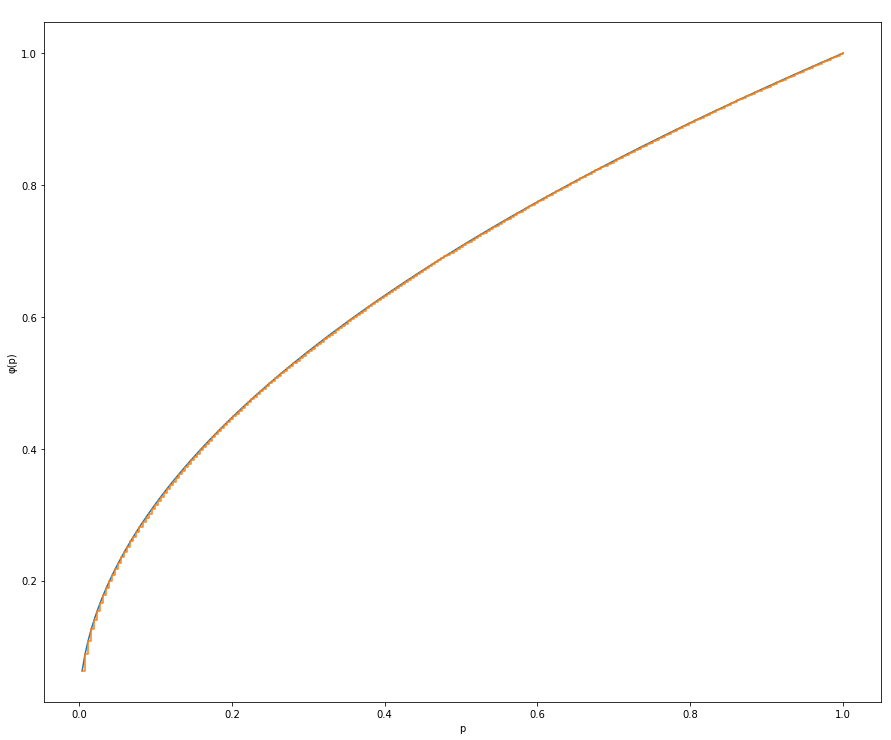

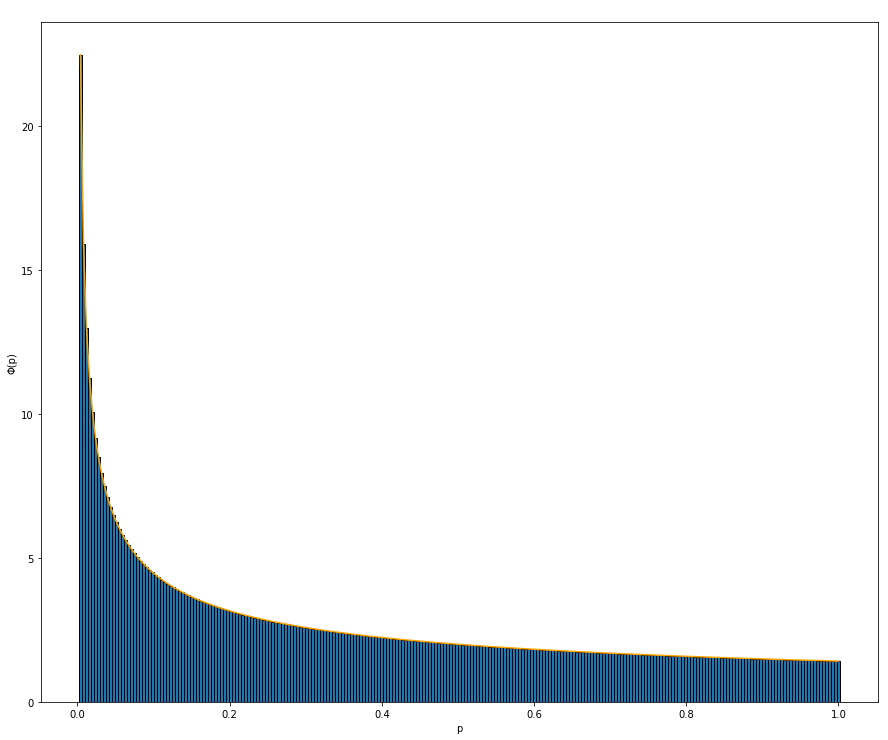

In [27]:
#-------------------------------------------------------
# Delta

gamma = 0.5
p = np.linspace(1/253, 253/253, 253)
phi = np.power(p, gamma)

def make_delta_for_plot(x):
    new_x=[val for val in x for _ in (0, 1)]
    new_x.pop(0)
    return new_x

def make_delta_for_plot2(y):
    new_y=[val for val in y for _ in (0, 1)]
    new_y.pop(-1)
    return new_y

new_x = make_delta_for_plot(p)
new_y = make_delta_for_plot2(phi)

plt.plot(p, phi)
plt.plot(new_x,new_y)
plt.xlabel('p')
plt.ylabel('\u03C6(p)')
plt.title(' ')
plt.show()

#-------------------------------------------------------
# Fläche

b = 0.5
p = np.array(np.arange(1/253, 253/253, 1/253))
phi_p = np.power((b * p), (b-1))
x = np.array(np.arange(1/253,253/253,1/253))

liste = []
for i in phi_p:
    liste.append(i)
y = liste

plt.plot(p, phi_p, color='orange')
plt.bar(x, liste, width=(1/253), edgecolor='black')
plt.xlabel('p')
plt.ylabel('\u03A6(p)')
plt.title(' ')
plt.show()

### Parameterfestlegung und Aufruf der Funktionen

In [ ]:
alpha = 0.1
VaR(alpha)

alpha = 0.1
CVaR(alpha)

gamma = 0.5
power(gamma)

## Risikomaße schätzen - Varianz-Kovarianz-Methode:

### Value at Risk

Die Berechnung des Value at Risk für die Varianz-Kovarianz-Methode ist analog zu der bei der historischen Simulation.
Der einzige Unterschied ist, dass hierbei auf die bei der für die analytische Verteilungsfunktion generierten Werte zurückgeriffen wird.

In [ ]:
RM_list = sorted(var_covar_range)

def VaR(alpha):
    item = int((alpha * len(RM_list)))
    VaR = RM_list[item]
    print('#------------------------------------------------------------------------------------------------------------------#')
    print('|' + centered('Der VaR beträgt: ' + str(VaR) + '.') + '| ')

### Conditional Value at Risk

Für den Conditional Value at Risk gilt selbiges.

In [ ]:
def CVaR(alpha):
    item = int((alpha * len(RM_list)))
    CVaR_list = RM_list[0:item]     
    CVaR = np.sum(CVaR_list) / len(CVaR_list)
    print('#------------------------------------------------------------------------------------------------------------------#')
    print('|' + centered('Der CVaR beträgt: ' + str(CVaR) + '.') + '| ')

### Power-Spektrales Risikomaß

Das Power-Spektrale Risikomaß für die Varianz-Kovarianz-Methode wird grundsätzlich wie das bei der historischen Simulation berechnet, wobei jedoch anstelle der historischen Portfolio-Realisationen auf (0,1) standardnormalverteilte Variablen zurückgegriffen wird, welche anschließend erneut mit einer subjektiven Wahrscheinlichkeit multipliziert werden.
Das so ermittelte Risiko der auf (0,1) standardiserten Normalverteilung wird dann mit der geschätzten Standardabweichung des Portfolios multipliziert und mit dem gescätzten Erwartungswert des Portfolios addiert.

In [ ]:
def power(gamma):
    global mu_PF
    global std_PF
    print('#------------------------------------------------------------------------------------------------------------------#')
    print('|' + centered('Power-Spektrales Risikomaß bei der Varianz-Kovarianz-Methode:') + '| ')
    print('#------------------------------------------------------------------------------------------------------------------#')
    print('|' + centered('Der Erwartungswert beträgt: ' + str(mu_PF) + '.') + '| ')
    print('|' + centered('Die Standardabweichung beträgt: ' + str(std_PF)+ '.') + '| ')

    array = np.array(np.arange(0.0001, 1, 0.0001))
    #array = np.array(np.arange(mini_values_PF, maxi_values_PF, 0.0001))
    
    counter0 = 0
    counter1 = len(array)-1
    counter2 = len(array)-2
    xq_list = []
    for i in range(0, len(array)):
        p = array[counter0]
        x = stats.norm.ppf(p, 0, 1)
        q = (np.power(array[counter1], gamma)) - (np.power(array[counter2], gamma))
        if counter0 == len(array)-1:
            q = (np.power(array[counter1], gamma))
        counter0 += 1
        counter1 -= 1
        counter2 -= 1
        xq = x*q
        xq_list.append(xq)
        
    risk_nv = np.sum(xq_list)
    risk = (mu_PF + std_PF * risk_nv)
    print('|' + centered('Das Risiko beträgt: ' + str(risk) + '.') + '| ')
    print('#------------------------------------------------------------------------------------------------------------------#')

### Parameterfestlegung und Aufruf der Funktionen

In [ ]:
alpha = 0.1
VaR(alpha)

alpha = 0.1
CVaR(alpha)

gamma = 0.5
power(gamma)